# Stabe Diffusion - Image Generation model
### From https://huggingface.co/stabilityai/stable-diffusion-2-1

In [1]:
!pip install -q diffusers transformers accelerate scipy safetensors xformers


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [15]:
import torch
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionImageVariationPipeline,
    DPMSolverMultistepScheduler
)

model_id = "stabilityai/stable-diffusion-2-1"

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
text2img = StableDiffusionPipeline.from_pretrained(model_id) #, torch_dtype=torch.float16)
# text2img.scheduler = DPMSolverMultistepScheduler.from_config(text2img.scheduler.config)

# Select GPU acceleration type, or comment out for CPU only
# pipe = pipe.to("cuda") # on NVidia GPU
text2img = text2img.to("mps") # on Mac M1/M2

# first time download takes some time (~5GB downlaod)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

API: https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/text2img#diffusers.StableDiffusionPipeline

In [16]:
prompt = "a photo of an astronaut riding a horse on mars"
image = text2img(prompt, num_inference_steps=30, guidance_scale=11).images[0]
    
# image.save("astronaut_rides_horse.png")

  0%|          | 0/30 [00:00<?, ?it/s]

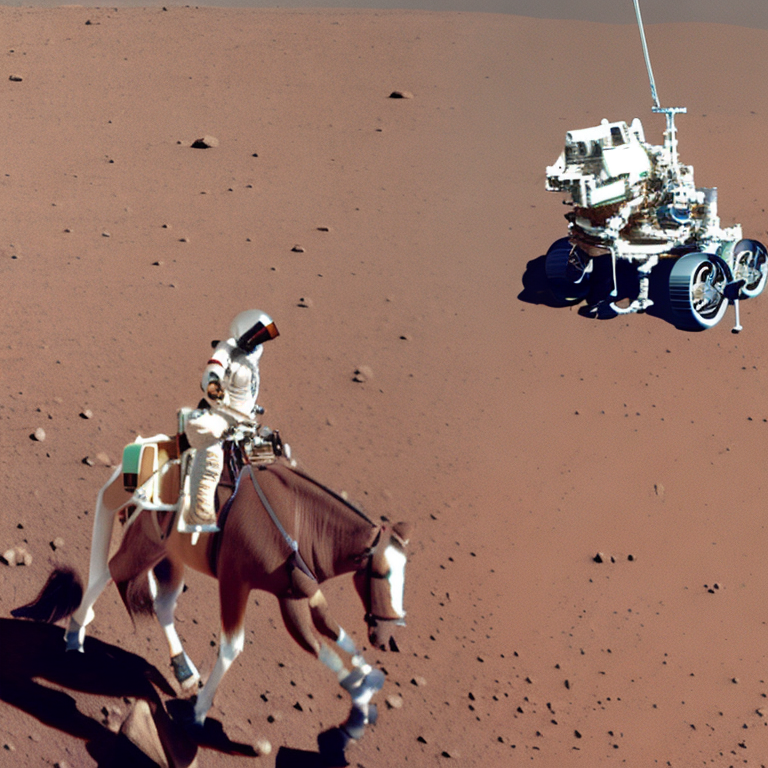

In [17]:
image

In [18]:
import requests
from PIL import Image
from io import BytesIO
url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((768, 512))

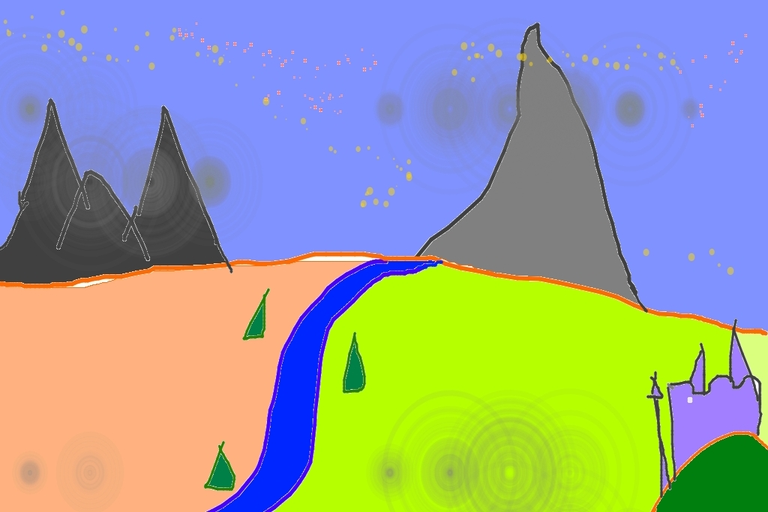

In [19]:
init_image

In [20]:
img2img = StableDiffusionImg2ImgPipeline(**text2img.components)
# img2img.scheduler = DPMSolverMultistepScheduler.from_config(img2img.scheduler.config)
img2img = img2img.to('mps')

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [21]:
image2 = img2img(prompt="A fantasy landscape, trending on artstation, hyper-realistic, ultra-detailed", image=init_image, strength=0.75, num_inference_steps=50, guidance_scale=7.5).images[0]


  0%|          | 0/37 [00:00<?, ?it/s]

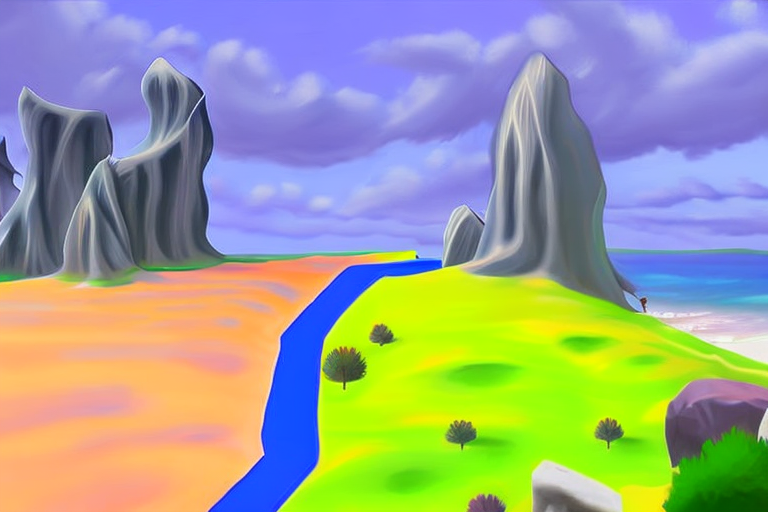

In [22]:
image2

## Image Variations

In [23]:
from torchvision import transforms

variationimg = StableDiffusionImageVariationPipeline.from_pretrained(
  "lambdalabs/sd-image-variations-diffusers",
  revision="v2.0",
  )
variationimg = variationimg #.to('mps')

tform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(
        (224, 224),
        interpolation=transforms.InterpolationMode.BICUBIC,
        antialias=False,
        ),
    transforms.Normalize(
      [0.48145466, 0.4578275, 0.40821073],
      [0.26862954, 0.26130258, 0.27577711]),
])
inp = tform(image) #.to('mps')

image_encoder/model.safetensors not found


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [24]:
inp.size()

torch.Size([3, 224, 224])

In [25]:
out = variationimg(inp.tile(1,1,1,1), guidance_scale=3)
out["images"][0]

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Image transformation with prompts Instructpix2pix

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


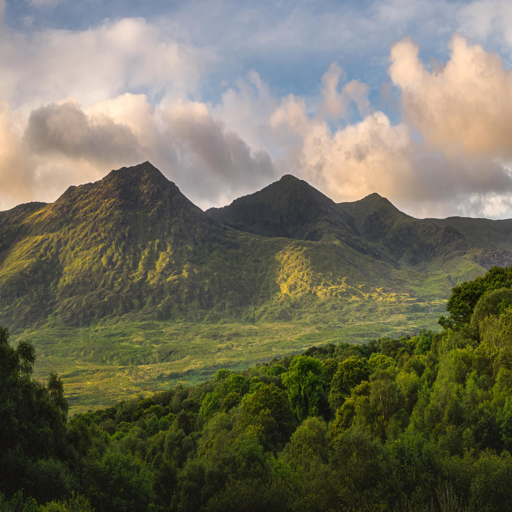

In [26]:
import PIL
import requests
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline

model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id) #, torch_dtype=torch.float16).to("cuda")
pipe = pipe.to('mps')

url = "https://huggingface.co/datasets/diffusers/diffusers-images-docs/resolve/main/mountain.png"


def download_image(url):
    image = PIL.Image.open(requests.get(url, stream=True).raw)
    image = PIL.ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image


image = download_image(url)
image

  0%|          | 0/20 [00:00<?, ?it/s]

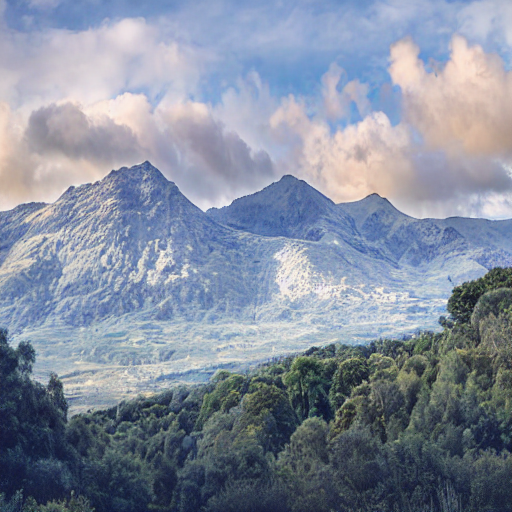

In [27]:
prompt = "make the mountains snowy"
output = pipe(prompt, image=image, num_inference_steps=20, image_guidance_scale=1.5, guidance_scale=7).images[0]
output